In [4]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim # 최적화 알고리즘들이 포함힘

import albumentations as A
from albumentations import *
from albumentations.pytorch import ToTensorV2

from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
from torchvision.models import resnet50

In [5]:
model_path = "/Users/rimo/Documents/paper/detector/classification/models/basic/20.pth"
image_folder = "/Users/rimo/Documents/paper/data/crop_images/"
data_csv = "/Users/rimo/Documents/paper/data/test_csv_.csv"

In [6]:
class resnet50(nn.Module):
    def __init__(self, num_classes):
        super(resnet50, self).__init__()
        self.net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
        self.net.fc = nn.Linear(in_features = 2048, out_features=num_classes, bias=True)
    def forward(self, x):
        x = self.net(x)
        return x

In [11]:
number_to_label = {0:"good", 1:"double", 2:"pull", 3:"crack"}
w,h = 620, 250
model = resnet50(4)
device = torch.device("cpu")
model.load_state_dict(torch.load(model_path, map_location=device)) # trained model
model = model.eval()

data = pd.read_csv(data_csv)
data = data[data["label"] != 0]
data = data[data["label"] != 1]
data = data[data["label"] != 2]
data = data[data["label"] != -1]

Using cache found in /Users/rimo/.cache/torch/hub/pytorch_vision_v0.10.0


In [12]:
# 특정 이미지를 모델에 입력하기 위한 전처리 함수
def transform_to_tensor(img_path):
    img = cv2.imread(img_path)
    img = Image.fromarray(img[:,:,:3])
    img = torchvision.transforms.Resize((h,w))(img)
    img = torchvision.transforms.ToTensor()(img)
    img = torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))(img)
    img = img.unsqueeze(0)
    return img

In [13]:
# 해당 모델에서 어떠한 layer에서 GradCAM을 추출해낼 것인지 선언
target_layers = [model.net.layer4[-1].conv3]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

 GT  :  crack
Pred :  crack


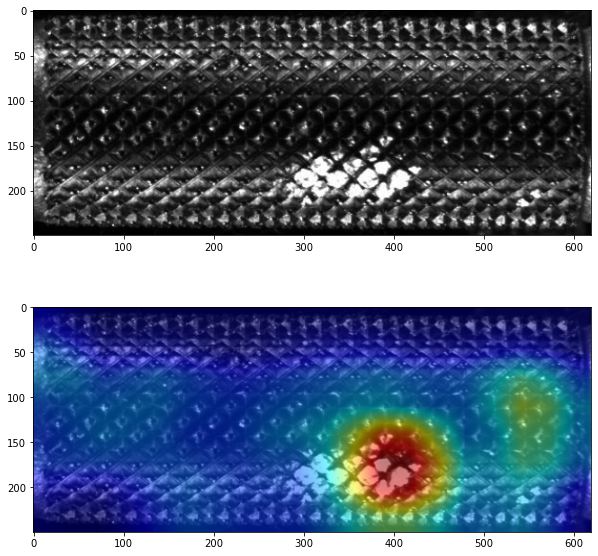

In [23]:
# 특정 이미지를 선택하여(ids) 해당 이미지로 예측을 진행하고, GradCAM을 적용해 시각화 해주는 단계
# ids = 100201
n=3
fig, axes = plt.subplots(2,1,figsize=(10,10))
axes = axes.flatten()

img_path = image_folder + data["image_path"].iloc[n]
print(" GT  : ",number_to_label[data["label"].iloc[n]])

image = cv2.imread(img_path)/255 # 원본 시각화를 위한 image
image = cv2.resize(image, dsize=(w, h))

img = transform_to_tensor(img_path) # image transform
pred = int(torch.argmax(torch.nn.Softmax()(model(img))).item()) # 예측값 반환
targets = [ClassifierOutputTarget(pred)] # 

grayscale_cam = cam(input_tensor=img, targets=targets)
grayscale_cam = grayscale_cam[0,:]
visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
visualization = cv2.resize(visualization, dsize=(620,250))
axes[1].imshow(visualization)
image = cv2.resize(image, dsize=(620,250))
axes[0].imshow(image)
# print(data["label_name"][ids])
print("Pred : ",number_to_label[pred])